In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
from tabulate import tabulate

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [44]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


In [45]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [46]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add
path="./csvs"
csv_list=find_the_way(path,".csv")
csv_list

['./csvs\\iris.csv']

# SPLIT DATA as TRAIN AND TEST

In [47]:
for name in csv_list:   
    print(name)
    df=pd.read_csv(name)#,header=None) 
    X =df[df.columns[0:-1]]
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y=df[df.columns[-1]]

    # setting up testing and training sets
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=27,stratify=y)

    # concatenate our training data back together
    train = pd.concat([X_train, y_train], axis=1)


    file=f"{name[0:-4]}_train.csv"
    

    train.to_csv(file,index=False)


    test= pd.concat([X_test, y_test], axis=1)

    file=name[0:-4]+"_"+"test.csv"
    test.to_csv(file.replace("train","test"),index=False)

./csvs\iris.csv


In [27]:
ml_list={"DT":DecisionTreeClassifier()}#,"SVC":SVC()}}

In [28]:
def target_name(name):
    df = pd.read_csv(name)
    target_names=sorted(list(df[df.columns[-1]].unique()))
    return target_names

In [29]:
folder("results")

## Calculation of evaluations

In [30]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=np.nan
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
def ML_CV(loop1,output_csv,cols,dname):
    fold=5
    repetition=10
    sw=np.nan
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        cm = pd.DataFrame()
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,index_col=0)#,header=None )
            #df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):


                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

      


                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

                
                
                
                
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)
                
                
                
                
                
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        del results["SW"]
        del results["ROC"]
        print (tabulate(results, headers=list(results.columns),tablefmt="double_grid"))
        #print()
        if True:
            cm=cm//(repetition*cv)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (10,7))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             




# 10 fold 10 times Cross-Validating

In [31]:
feature=["sepal.length","sepal.width","petal.length","petal.width","variety"]

In [32]:
train="./csvs/iris.csv"
output_csv="./results/CV.csv"
target_names=target_name(train)
dname="IRIS_10X10_CV"

╔════╦═══════════════╦═════╦══════╦══════╦═══════╦═════════╦════════╦═══════╦═══════╦═══════╦═════════╦══════════╗
║    ║ Dataset       ║   T ║   CV ║ ML   ║   Acc ║   b_Acc ║   Prec ║   Rec ║    F1 ║   kap ║   tra-T ║   test-T ║
╠════╬═══════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══════╬═══════╬═════════╬══════════╣
║  0 ║ IRIS_10X10_CV ║   1 ║    0 ║ DT   ║ 0.933 ║   0.939 ║  0.944 ║ 0.939 ║ 0.936 ║ 0.9   ║   0.001 ║    0     ║
╠════╬═══════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══════╬═══════╬═════════╬══════════╣
║  1 ║ IRIS_10X10_CV ║   2 ║    0 ║ DT   ║ 0.967 ║   0.963 ║  0.963 ║ 0.963 ║ 0.961 ║ 0.949 ║   0.001 ║    0     ║
╠════╬═══════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══════╬═══════╬═════════╬══════════╣
║  2 ║ IRIS_10X10_CV ║   3 ║    0 ║ DT   ║ 0.967 ║   0.972 ║  0.974 ║ 0.972 ║ 0.972 ║ 0.948 ║   0     ║    0     ║
╠════╬═══════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══

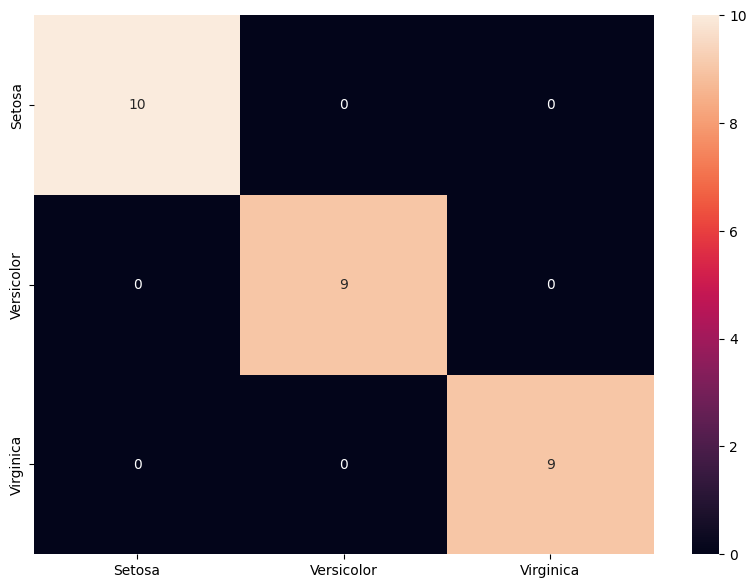

In [33]:
ML_CV(train,output_csv,feature,dname)   

# seperated train test

In [35]:
def ML(loop1,loop2,output_csv,cols,dname):
    fold=5
    repetition=100
    sw=np.nan
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        cm = pd.DataFrame()
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  



      


            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)





            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)



                
                
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        del results["SW"]
        del results["ROC"]
        print (tabulate(results, headers=list(results.columns),tablefmt="double_grid"))
       
        
        #print()
        if True:
            cm=cm//(repetition*cv)
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (10,7))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             




In [36]:
train="./csvs/iris_train.csv"
test="./csvs/iris_test.csv"
output_csv="./results/100R.csv"
target_names=target_name(train)
dname="IRIS_100_times"


╔════╦════════════════╦═════╦══════╦══════╦═══════╦═════════╦════════╦═══════╦═══════╦═══════╦═════════╦══════════╗
║    ║ Dataset        ║   T ║   CV ║ ML   ║   Acc ║   b_Acc ║   Prec ║   Rec ║    F1 ║   kap ║   tra-T ║   test-T ║
╠════╬════════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══════╬═══════╬═════════╬══════════╣
║  0 ║ IRIS_100_times ║   1 ║    0 ║ DT   ║ 0.921 ║   0.923 ║  0.933 ║ 0.923 ║ 0.919 ║ 0.882 ║   0.001 ║    0     ║
╠════╬════════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══════╬═══════╬═════════╬══════════╣
║  1 ║ IRIS_100_times ║   1 ║    1 ║ DT   ║ 0.921 ║   0.923 ║  0.933 ║ 0.923 ║ 0.919 ║ 0.882 ║   0.001 ║    0     ║
╠════╬════════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬═══════╬═══════╬═══════╬═════════╬══════════╣
║  2 ║ IRIS_100_times ║   1 ║    2 ║ DT   ║ 0.921 ║   0.923 ║  0.933 ║ 0.923 ║ 0.919 ║ 0.882 ║   0     ║    0     ║
╠════╬════════════════╬═════╬══════╬══════╬═══════╬═════════╬════════╬══

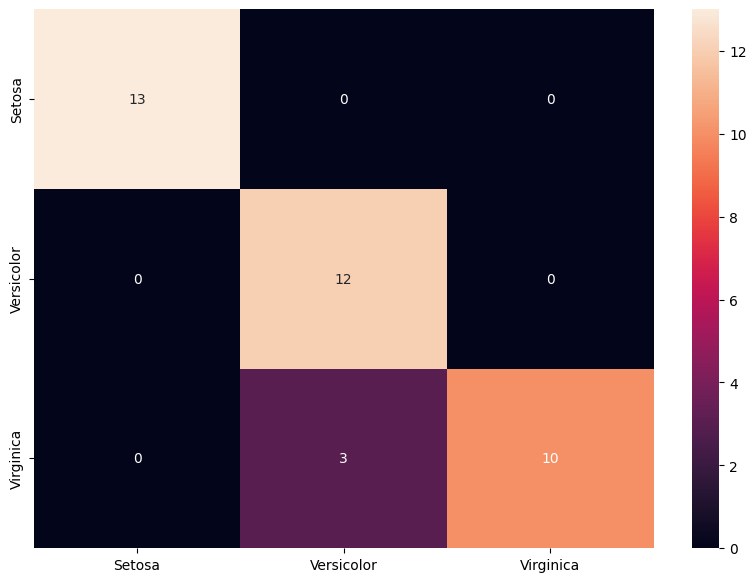

In [37]:
ML(train,test,output_csv,feature,dname)   

In [39]:
def dt_fi(loop1,cols,graph_name="./results/1.pdf"):
    df = pd.read_csv(loop1,usecols=cols)#,index_col=0)#,header=None )
    #df = df.reset_index(drop=True)
    df=df.fillna(0)

    #del df["MAC"] # if dataset has MAC colomn please uncomment this line
    X =df[df.columns[0:-1]]

    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y=df[df.columns[-1]].cat.codes  
    X.shape

    # define the model
    model = DecisionTreeClassifier()
    # fit the model
    model.fit(X, y)
    # get importance
    importance = model.feature_importances_
    # summarize feature importance
    my_xticks=list(X.columns)
    lines={"Feature Name":my_xticks,"Score":importance}
    results = pd.DataFrame (lines)
    print (tabulate(results, headers=list(results.columns)))
    
    plt.bar(my_xticks, importance)
    plt.title("DT feature Importance Scores ")
    #plt.legend(numpoints=1)
    plt.ylabel("FI Score")
    plt.xticks(rotation=90) 
    #plt.ylim([-10, 110]) 
    plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()

    Feature Name        Score
--  --------------  ---------
 0  sepal.length    0.0312525
 1  sepal.width     0
 2  petal.length    0.0456195
 3  petal.width     0.923128


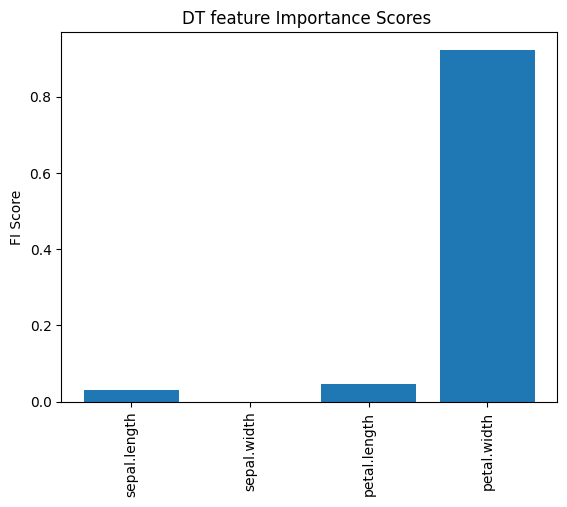

In [41]:
dt_fi(train,feature,"./results/DT feature Importance Scores.pdf")   